# Chihuahua vs Muffin Classifier using Convolutional Neural Networks

# 1. Introduction

In this lab, we'll build upon our previous workshop where we used a traditional Neural Network (NN) to classify images as either Chihuahuas or muffins. This time, we'll use a Convolutional Neural Network (CNN), which is particularly well-suited for image classification tasks because it can learn spatial hierarchies of features directly from the image data.
By the end of this lab, we'll compare the performance of our CNN model with the traditional NN from the previous workshop.

This is what we'll do in this lab:
#### 1) Build the  convolutional neural network
#### 2) Load the data
#### 3) Train the model on the data
#### 4) Visualize the results

### Remember: This is an INTERACTIVE Notebook!
You should run and play with the code as you go to see how it works. Select a cell and **press shift-enter to execute code.**

Let's get started!

# 2.  Setup and Imports

Let's get to the fun stuff!
First, we need to Install and  import the necessary libraries. Each import serves a specific purpose in our project.
python


In [ ]:
 !git clone https://github.com/patitimoner/workshop-chihuahua-vs-muffin.git
 %cd workshop-chihuahua-vs-muffin
 !ls

Cloning into 'workshop-chihuahua-vs-muffin'...
remote: Enumerating objects: 337, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 337 (delta 1), reused 4 (delta 1), pack-reused 330 (from 1)
Receiving objects: 100% (337/337), 14.51 MiB | 28.91 MiB/s, done.
Resolving deltas: 100% (82/82), done.
/content/workshop-chihuahua-vs-muffin/workshop-chihuahua-vs-muffin
'CNN_1 Chihuahua or Muffin.ipynb'   README.md   workshop_1.ipynb
 data				    resources   workshop_1_output.ipynb


In [ ]:
!pip install torch --upgrade
!pip install torchvision --upgrade

In [ ]:
import numpy as np                          # Numpy for matrix operations
import torch                                 # PyTorch deep learning framework
import torch.nn as nn                        # Neural network module of PyTorch
import torch.optim as optim                  # Optimization algorithms
from torchvision import datasets, transforms # Tools for loading and transforming image data
from torch.utils.data import DataLoader      # Efficient data loading
import matplotlib.pyplot as plt              # For plotting and visualization. It is graphical library, to plot images
# special Jupyter notebook command to show plots inline instead of in a new window
%matplotlib inline
from tqdm import tqdm                        # For progress bars during training

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# 3 Data Preparation
Before we start training our model, it's crucial to separate our data into training and testing (validation) sets. This separation is a fundamental concept in machine learning that helps us assess how well our model generalizes to unseen data.

## 3.1 Understanding Train-Test Split
In machine learning, we typically divide our dataset into two main subsets:

1. **Training set:** This is the larger portion of the data that we use to train our model. The model learns the patterns and features from this data.
2. **Testing set** (also called Validation set): This is a smaller portion of the data that we set aside and don't use during training. We use this to evaluate how well our model performs on unseen data.

The reason for this split is to simulate how our model would perform on new, unseen data in the real world. If we tested on the same data we used for training, we wouldn't know if our model was truly learning general patterns or just memorizing the training data (a problem called overfitting).



In [ ]:
import os

print("Data contents:", os.listdir("data"))
print("Train contents:", os.listdir("data/train"))
print("Validation contents:", os.listdir("data/validation"))

# Count the number of images in each set
train_chihuahuas = len(os.listdir("data/train/chihuahua"))
train_muffins = len(os.listdir("data/train/muffin"))
val_chihuahuas = len(os.listdir("data/validation/chihuahua"))
val_muffins = len(os.listdir("data/validation/muffin"))

print(f"Training set: {train_chihuahuas} Chihuahuas, {train_muffins} Muffins")
print(f"Validation set: {val_chihuahuas} Chihuahuas, {val_muffins} Muffins")

Data contents: ['train', 'validation']
Train contents: ['chihuahua', 'muffin']
Validation contents: ['chihuahua', 'muffin']
Training set: 65 Chihuahuas, 55 Muffins
Validation set: 17 Chihuahuas, 13 Muffins



## 3.2 Dataset Structure
In our case, we've already separated our data into train and validation sets in our file structure:
You should see that we have two main directories (same dataset as previous exercise): 'train' and 'validation', each containing subdirectories for our classes (Chihuahua and Muffin).

## 3.3 Loading Separated Datasets
Now, let's load our separated datasets:
Remember we have to load all the images and convert them into a form that our neural network understands. Specifically, PyTorch works with **Tensor** objects. (A tensor is just a multidimensional matrix, i.e. an N-d array.)

## 3.4 Define Data transformations
Now that we understand our dataset, let's define the transformations we'll apply to our images. These transformations help in data augmentation and normalization.
**To easily convert our image data into tensors, we use the help of a "dataloader."** The dataloader packages data into convenient boxes for our model to use. You can think of it like one person passing boxes (tensors) to another.


In [ ]:
from torchvision import transforms
#  Define image dimensions
input_height, input_width = 224, 224

# Define data transforms for training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_height, input_width)),  # Resize images
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.RandomRotation(10),  # Randomly rotate images
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
    ]),
    'validation': transforms.Compose([
        transforms.Resize((input_height, input_width)),  # Resize images
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
    ])
}

## 3.5 Create Dataset and Dataloader
With our transformations defined, we can now create our datasets and dataloaders. These will efficiently feed data into our model during training.

In [ ]:
# Load datasets
image_datasets = {
    'train': datasets.ImageFolder('data/train', data_transforms['train']),
    'validation': datasets.ImageFolder('data/validation', data_transforms['validation'])
}

# Create dataloaders
batch_size = 32
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
    'validation': DataLoader(image_datasets['validation'], batch_size=batch_size, shuffle=False, num_workers=4)
}

# Get the number of classes
num_classes = len(image_datasets['train'].classes)
print(f"Number of classes: {num_classes}")

# Print dataset sizes
print(f"Training samples: {len(image_datasets['train'])}")
print(f"Validation samples: {len(image_datasets['validation'])}")

Number of classes: 2
Training samples: 120
Validation samples: 30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Let's break down what this code does:

1. We define separate data transforms for training and validation sets. The training set includes data augmentation (random flips and rotations) to increase variety in our training data, while the validation set doesn't use augmentation.

2. We use datasets.ImageFolder to load our images from the 'train' and 'validation' directories. This function automatically assigns labels based on the subdirectory names.

3. We create DataLoader objects for both sets. These handle batching our data and shuffling the training set (but not the validation set, as order doesn't matter for validation).

4. Finally, we print the sizes of our datasets to confirm the split.

By using separate dataloaders for training and validation, we ensure that our model is evaluated on data it hasn't seen during training, giving us a more accurate assessment of its performance.

# 4. Model Definition
Now that we've prepared our data, we can define our CNN model. We'll use the information about our input dimensions and number of classes to structure our network.

In [ ]:
class ChihuahuaMuffinCNN(nn.Module):
    def __init__(self, input_channels=3, num_classes=num_classes):
        super(ChihuahuaMuffinCNN, self).__init__()

        # Convolutional layers
        self.features = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second convolutional layer
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third convolutional layer
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(128 * (input_height//8) * (input_width//8), 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)  # Pass input through convolutional layers
        x = torch.flatten(x, 1)  # Flatten the output for the fully connected layers
        x = self.classifier(x)  # Pass through the fully connected layers
        return x

# Initialize the model and move it to the appropriate device
model = ChihuahuaMuffinCNN().to(device)
print(model)

# Print model summary
from torchsummary import summary
summary(model, (3, input_height, input_width))

ChihuahuaMuffinCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=100352, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=2, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU

# 5. Training Setup
With our model defined, we now need to set up our loss function and optimizer. These are crucial components for training our network. In deep learning, they are the  two key components for training: Let's  recap and understand what these are and how we'll use them.

**Loss Function**
The loss function measures how well our model is performing. It calculates the difference between our model's predictions and the true labels. For our classification task, we'll use Cross Entropy Loss, which is well-suited for multi-class classification problems.

**Optimizer**
The optimizer is responsible for updating our model's parameters to minimize the loss function. We'll use the Adam optimizer, which is an extension of stochastic gradient descent (SGD) that adapts the learning rate for each parameter.

Let's define our loss function and optimizer:


In [ ]:
# Define the loss function (Cross Entropy for classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam) with learning rate 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Loss function:", criterion)
print("Optimizer:", optimizer)

Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


### In this code:

nn.CrossEntropyLoss() creates our loss function.
optim.Adam(model.parameters(), lr=0.001) creates our optimizer. We pass it our model's parameters and set a learning rate of 0.001.

# 6. Model Trainning
Now we're ready to train our model. We'll define a function to handle the training process and then run it for a specified number of epochs.

This function will:
- Iterate over our data for a specified number of epochs

In each epoch, it will:
- Train on the training data
- Evaluate on the validation data

Keep track of and print our loss and accuracy for both training and validation sets
This will start the training process. You'll see progress bars for each epoch, along with loss and accuracy metrics for both training and validation sets.

The training process may take some time, depending on your hardware. Once it's complete, we'll have a trained model ready for making predictions!

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

    return model

# Train the model
trained_model = train_model(model, dataloaders, criterion, optimizer, num_epochs=10)

print("Training complete!")

Epoch 1/10
----------


train: 100%|██████████| 4/4 [00:25<00:00,  6.27s/it]


train Loss: 3.8913 Acc: 0.5250


validation: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


validation Loss: 0.7767 Acc: 0.5667

Epoch 2/10
----------


train: 100%|██████████| 4/4 [00:26<00:00,  6.62s/it]


train Loss: 0.6920 Acc: 0.5583


validation: 100%|██████████| 1/1 [00:07<00:00,  7.85s/it]


validation Loss: 0.5423 Acc: 0.6333

Epoch 3/10
----------


train: 100%|██████████| 4/4 [00:24<00:00,  6.02s/it]


train Loss: 0.4597 Acc: 0.8500


validation: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


validation Loss: 0.2498 Acc: 1.0000

Epoch 4/10
----------


train: 100%|██████████| 4/4 [00:21<00:00,  5.38s/it]


train Loss: 0.2923 Acc: 0.9000


validation: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


validation Loss: 0.2125 Acc: 0.8667

Epoch 5/10
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.65s/it]


train Loss: 0.3020 Acc: 0.8750


validation: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


validation Loss: 0.8515 Acc: 0.6667

Epoch 6/10
----------


train: 100%|██████████| 4/4 [00:23<00:00,  5.81s/it]


train Loss: 0.3635 Acc: 0.9000


validation: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


validation Loss: 0.1116 Acc: 0.9667

Epoch 7/10
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.74s/it]


train Loss: 0.3233 Acc: 0.8667


validation: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


validation Loss: 0.2971 Acc: 0.8333

Epoch 8/10
----------


train: 100%|██████████| 4/4 [00:24<00:00,  6.05s/it]


train Loss: 0.1840 Acc: 0.9250


validation: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


validation Loss: 0.1264 Acc: 1.0000

Epoch 9/10
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.68s/it]


train Loss: 0.2197 Acc: 0.9083


validation: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


validation Loss: 0.3020 Acc: 0.8667

Epoch 10/10
----------


train: 100%|██████████| 4/4 [00:22<00:00,  5.51s/it]


train Loss: 0.1765 Acc: 0.9667


validation: 100%|██████████| 1/1 [00:03<00:00,  3.28s/it]

validation Loss: 0.1924 Acc: 0.9333

Training complete!


 ###This function does the following:

1. For each epoch:
-  It trains the model on the training data.
-  It then evaluates the model on the validation data.
-  For both phases, it calculates and prints the average loss and accuracy.


2. The model.train() and model.eval() calls ensure the model behaves appropriately for training and validation phases.

3. We use torch.set_grad_enabled() to only calculate gradients during the training phase.

4. In the training phase, we perform backpropagation (loss.backward()) and update the model parameters (optimizer.step()).

# 7. Examine model performance (Model Evaluation)
Finally, let's evaluate our trained model on the validation set and visualize some of its predictions.

Validation Accuracy: 0.9333


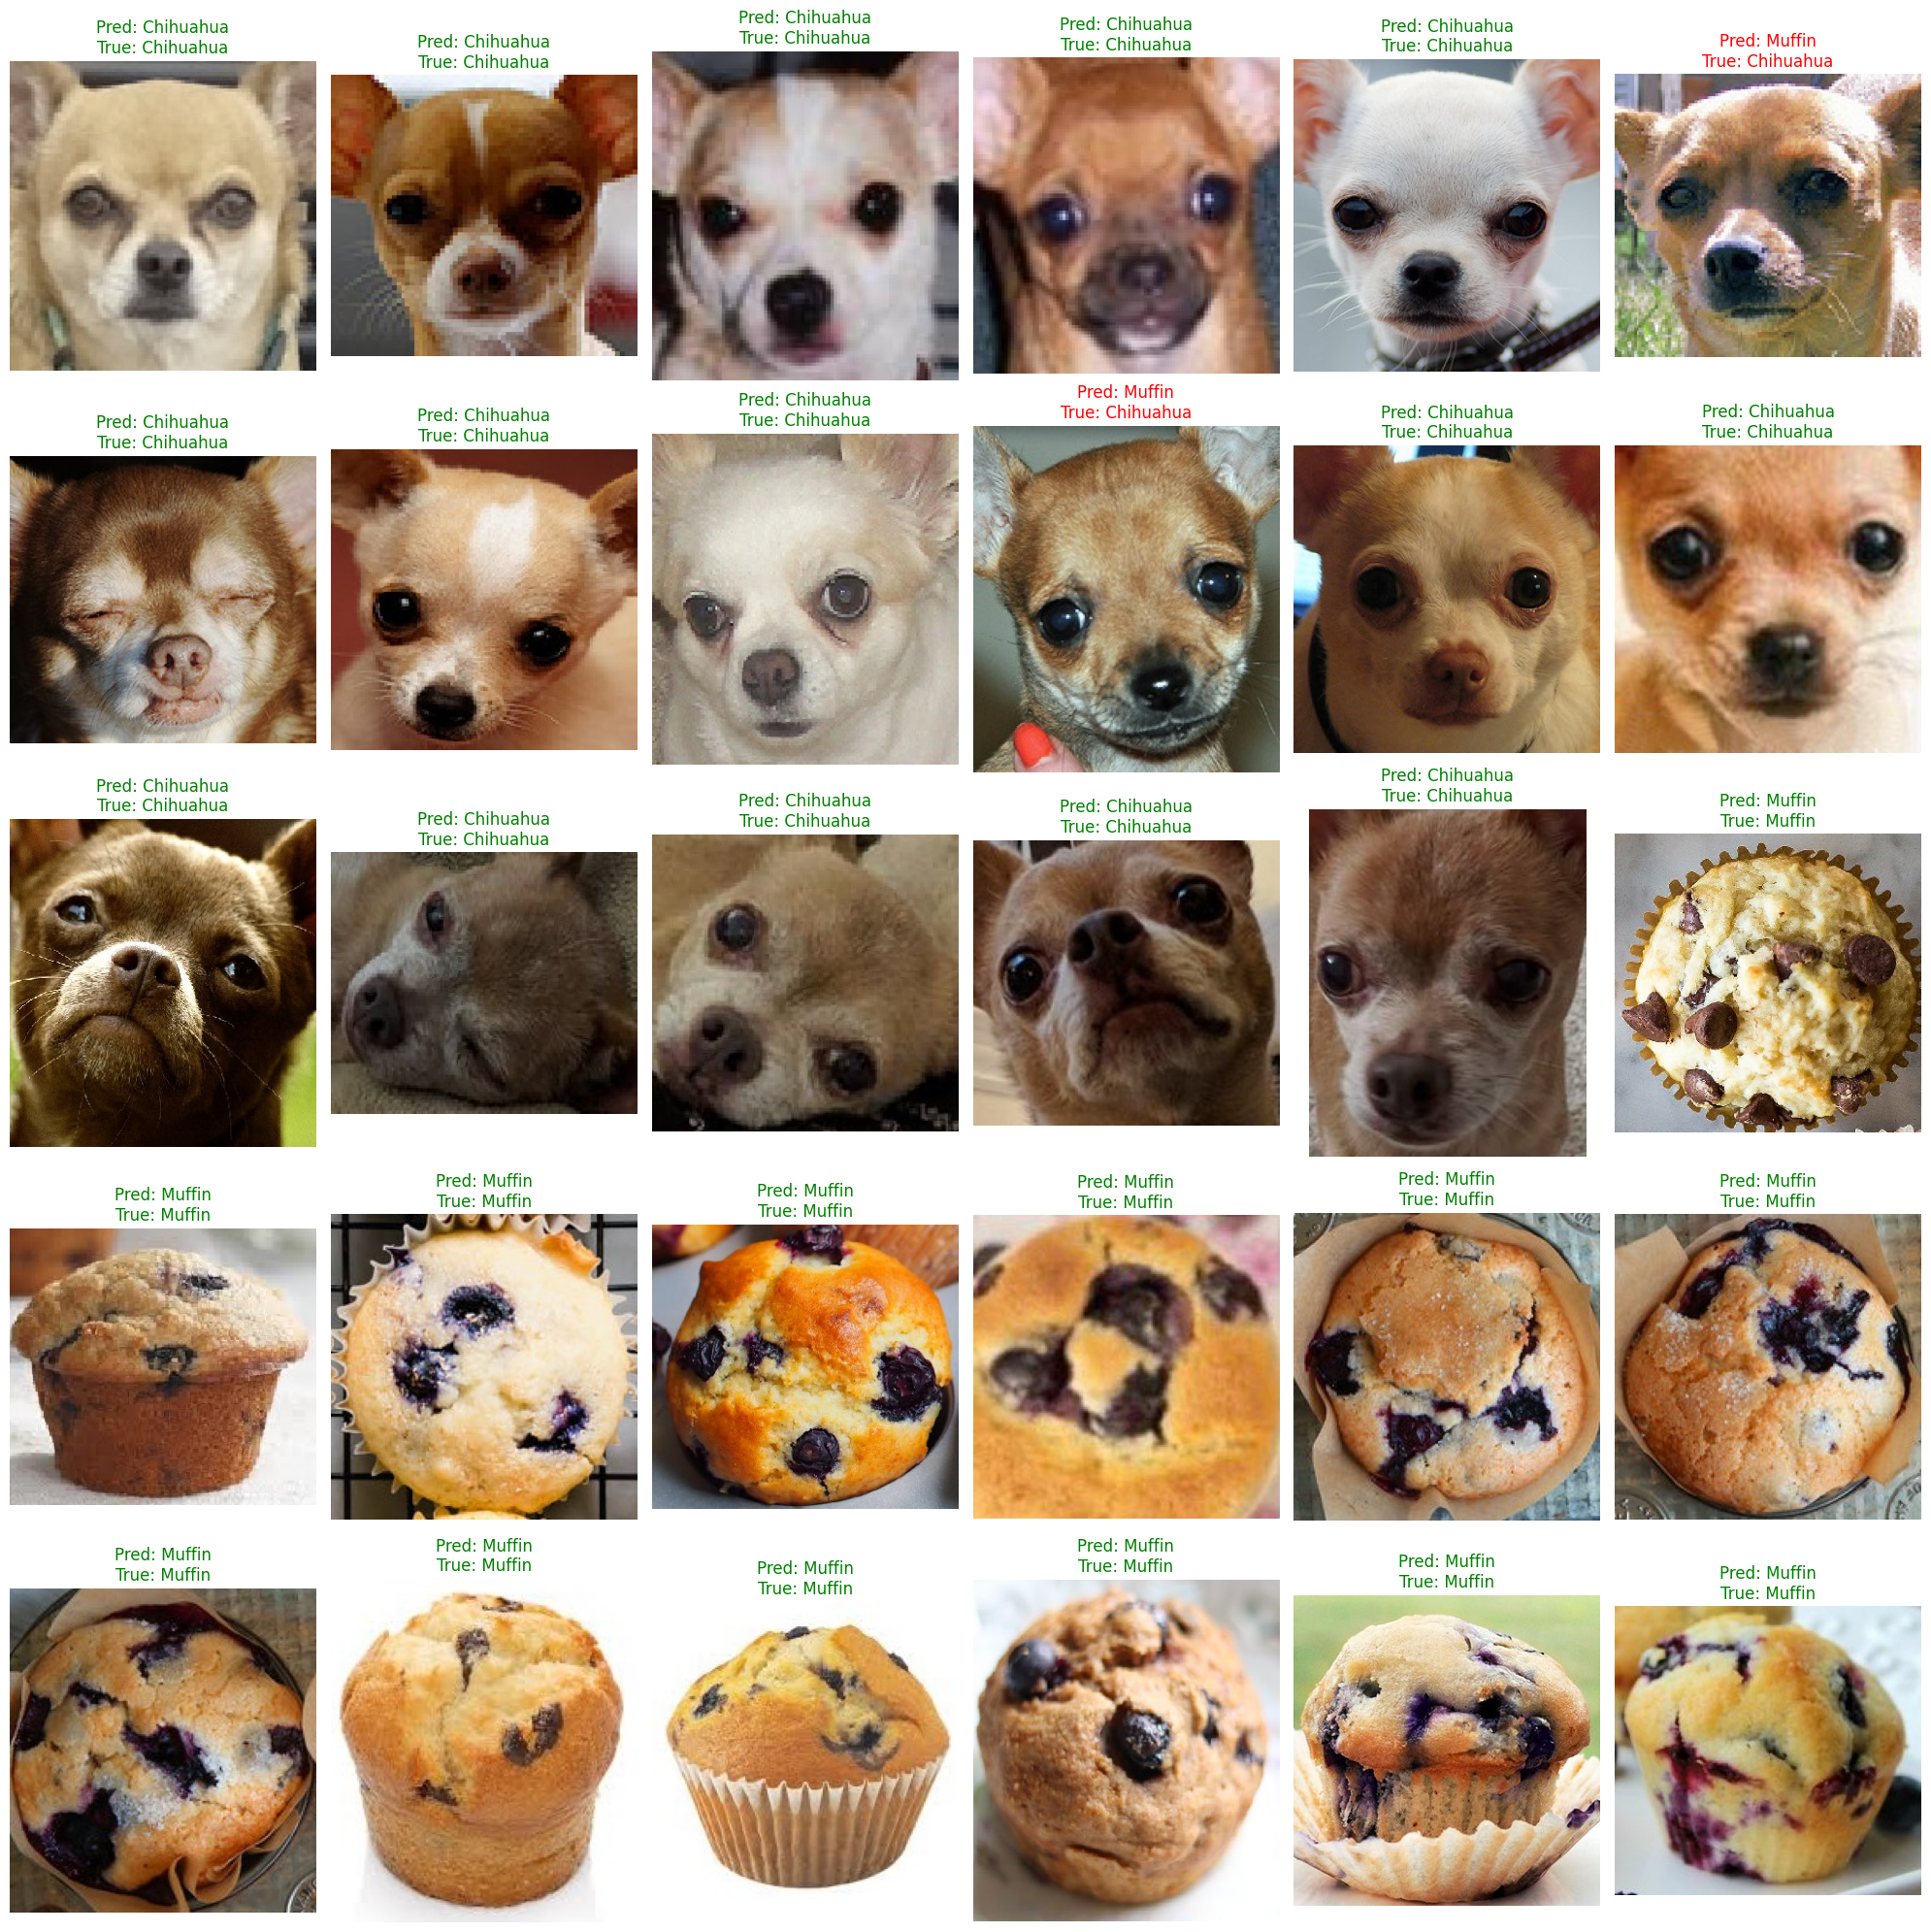

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return all_preds, all_labels

# Get predictions
val_preds, val_labels = evaluate_model(trained_model, dataloaders['validation'])

# Calculate accuracy
accuracy = sum(np.array(val_preds) == np.array(val_labels)) / len(val_labels)
print(f"Validation Accuracy: {accuracy:.4f}")

# Visualize some predictions
def plot_results(images, preds, labels):
    fig, axs = plt.subplots(5, 6, figsize=(20, 20))
    for i, (img_path, pred, label) in enumerate(zip(image_datasets['validation'].imgs, preds, labels)):
        img = plt.imread(img_path[0])
        ax = axs[i // 6, i % 6]
        ax.imshow(img)
        ax.axis('off')
        color = 'green' if pred == label else 'red'
        ax.set_title(f"Pred: {'Chihuahua' if pred == 0 else 'Muffin'}\nTrue: {'Chihuahua' if label == 0 else 'Muffin'}", color=color)
    plt.tight_layout()
    plt.show()

plot_results(image_datasets['validation'].imgs, val_preds, val_labels)

# 8.  Conclusion and Reflection

Congratulations! You've successfully built, trained, and evaluated a CNN for classifying Chihuahuas and Muffins. Here are some reflection questions to consider:

How does the performance of this CNN compare to the traditional Neural Network from the previous workshop?
What role do the convolutional layers play in image classification?
How might you further improve this model's performance?
What challenges might this model face in real-world applications?
How does data augmentation (like random flips and rotations) contribute to the model's performance?
What are the ethical considerations in developing and deploying an image classification system like this?

Remember to support your answers with references to relevant literature or resources on deep learning and computer vision. Good luck with your reflective journal!

 If you want  you can play with some hyperparameters to play with:
- Number of epochs
- The learning rate "lr" parameter in the optimizer
- The type of optimizer (https://pytorch.org/docs/stable/optim.html)
- Number of layers and layer dimensions
- Image size
- Data augmentation transforms (https://pytorch.org/docs/stable/torchvision/transforms.html)

# Special Thanks!

Credit for the original idea and code goes to [DeepSense.ai](https://deepsense.ai/keras-vs-pytorch-avp-transfer-learning/)!
I've modified it significantly to cater to this Lab.

The original tutorial was created through hard work and love by Jing Zhao, Dylan Wang, Jason Do, Jason Jiang, and Andrew Jong.